### Import relevant libraries

In [1]:
import pathlib
import os
import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# %load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import prd_pipeline#_fractions as prd_pipeline

In [7]:
# import mlflow
# mlflow.tensorflow.autolog()

### Load data

In [8]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis') / 'storm_dennis_6hr_lt'

In [9]:
filename = 'prd_merged_006H_20200214T1800Z_20200217T0000Z.csv'
data = pd.read_csv(
    data_dir / filename,
    index_col=0)

In [10]:
target_parameter = [col for col in data.columns if col.startswith('fraction')]
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'cloud_volume_fraction', 'wind_from_direction']
single_lvl_features = []#['air_pressure_at_sea_level'] 

In [11]:
tmp_data = data[data['mean_rain']>0]['mean_rain']

In [12]:
feature_dict = {'profile': profile_features,
                'single_level': single_lvl_features,
                'target': target_parameter,
               } 

In [13]:
data = data[data[target_parameter].sum(axis=1)>0.99]

### Data pre-processing

In [17]:
list(target_parameter)

['fraction_in_band_0.0',
 'fraction_in_band_0.03',
 'fraction_in_band_0.09',
 'fraction_in_band_0.1',
 'fraction_in_band_0.25',
 'fraction_in_band_0.3',
 'fraction_in_band_0.5',
 'fraction_in_band_1.0',
 'fraction_in_band_2.0',
 'fraction_in_band_3.0',
 'fraction_in_band_4.0',
 'fraction_in_band_8.0',
 'fraction_in_band_12.0',
 'fraction_in_band_16.0',
 'fraction_in_band_20.0',
 'fraction_in_band_25.0',
 'fraction_in_band_30.0',
 'fraction_in_band_40.0',
 'fraction_in_band_50.0',
 'fraction_in_band_75.0',
 'fraction_in_band_100.0',
 'fraction_in_band_150.0',
 'fraction_in_band_200.0']

In [14]:
data_splits, data_dims_dict = prd_pipeline.preprocess_data(data, feature_dict, test_fraction=0.2, test_savefn='test.csv')

{'profile': ['air_temperature', 'relative_humidity', 'wind_speed', 'cloud_volume_fraction', 'wind_from_direction'], 'single_level': [], 'target': ['fraction_in_band_0.0', 'fraction_in_band_0.03', 'fraction_in_band_0.09', 'fraction_in_band_0.1', 'fraction_in_band_0.25', 'fraction_in_band_0.3', 'fraction_in_band_0.5', 'fraction_in_band_1.0', 'fraction_in_band_2.0', 'fraction_in_band_3.0', 'fraction_in_band_4.0', 'fraction_in_band_8.0', 'fraction_in_band_12.0', 'fraction_in_band_16.0', 'fraction_in_band_20.0', 'fraction_in_band_25.0', 'fraction_in_band_30.0', 'fraction_in_band_40.0', 'fraction_in_band_50.0', 'fraction_in_band_75.0', 'fraction_in_band_100.0', 'fraction_in_band_150.0', 'fraction_in_band_200.0']}


In [15]:
data_splits['y_train']

,fraction_in_band_0.0,fraction_in_band_0.03,fraction_in_band_0.09,fraction_in_band_0.1,fraction_in_band_0.25,fraction_in_band_0.3,fraction_in_band_0.5,fraction_in_band_1.0,fraction_in_band_2.0,fraction_in_band_3.0,...,fraction_in_band_16.0,fraction_in_band_20.0,fraction_in_band_25.0,fraction_in_band_30.0,fraction_in_band_40.0,fraction_in_band_50.0,fraction_in_band_75.0,fraction_in_band_100.0,fraction_in_band_150.0,fraction_in_band_200.0
0,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
1,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
2,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
3,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
4,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209745,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209748,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209749,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209750,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


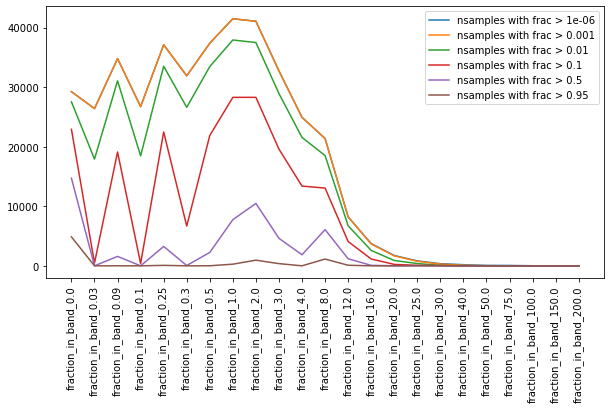

In [16]:
for frac in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(23):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > frac))
    plt.plot(np.arange(23), exceeding_prob, label=f'nsamples with frac > {frac}')
plt.xticks(np.arange(23), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

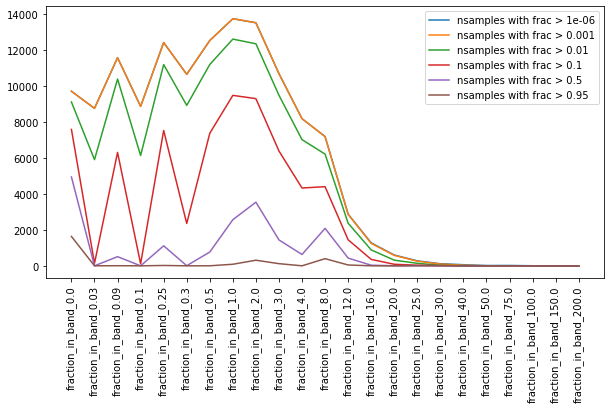

In [17]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(23):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(23), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(23), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [18]:
# data_splits['y_train']['fraction_greater_than_25.0'] = (
#     data_splits['y_train'][['fraction_in_band_25.0','fraction_in_band_30.0','fraction_in_band_40.0','fraction_in_band_50.0', 'fraction_in_band_75.0', 'fraction_in_band_100.0', 'fraction_in_band_150.0', 'fraction_in_band_200.0']].sum(axis=1)
# )
# data_splits['y_train'].insert(1,'fraction_in_band_0.03_0.1', data_splits['y_train'][['fraction_in_band_0.03','fraction_in_band_0.09', 'fraction_in_band_0.1']].sum(axis=1))
# # data_splits['y_train']['fraction_in_band_0.03_0.1'] = data_splits['y_train'][['fraction_in_band_0.03','fraction_in_band_0.09', 'fraction_in_band_0.1']].sum(axis=1)
# data_splits['y_train']['max_bin'] = data_splits['y_train'].idxmax(axis=1)

In [35]:
data_splits['y_train'] = data_splits['y_train'].drop(columns=['index'])

In [36]:
data_splits['y_val']

,fraction_in_band_0.0,fraction_in_band_0.03,fraction_in_band_0.09,fraction_in_band_0.1,fraction_in_band_0.25,fraction_in_band_0.3,fraction_in_band_0.5,fraction_in_band_1.0,fraction_in_band_2.0,fraction_in_band_3.0,...,fraction_in_band_16.0,fraction_in_band_20.0,fraction_in_band_25.0,fraction_in_band_30.0,fraction_in_band_40.0,fraction_in_band_50.0,fraction_in_band_75.0,fraction_in_band_100.0,fraction_in_band_150.0,fraction_in_band_200.0
4,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
8,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
11,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
16,0.622250,0.00482,0.044449,0.005193,0.061234,0.014541,0.047051,0.08,0.075385,0.028095,...,0.000003,0.0,0.0,0.000001,0.000001,0.0,0.000003,0.0,0.0,0.0
19,0.000000,0.00000,0.000000,0.000000,0.480861,0.311005,0.208134,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209741,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209743,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209745,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
209751,0.915033,0.00000,0.026144,0.000000,0.039216,0.006536,0.013072,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [20]:
nsamples = 10000

In [21]:
y_train = pd.DataFrame()

In [23]:
# data_splits['y_train'] = data_splits['y_train'].reset_index()
# for col in data_splits['y_train'].columns:
#     ids = data_splits['y_train'][data_splits['y_train']['max_bin']==col].index
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, data_splits['y_train'].loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

In [25]:
# from collections import Counter
# Counter(data_splits['y_train']['max_bin'])

In [26]:
# cols = ['fraction_in_band_0.0', 'fraction_in_band_0.03_0.1']+target_parameter[5:-7]+['fraction_greater_than_25.0']
# plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
# plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
# plt.legend()

In [ ]:
# y_train = y_train.drop(columns=['index', 'max_bin', 'fraction_in_band_25.0','fraction_in_band_30.0','fraction_in_band_40.0','fraction_in_band_50.0', 'fraction_in_band_75.0', 'fraction_in_band_100.0', 'fraction_in_band_150.0', 'fraction_in_band_200.0', 'fraction_in_band_0.03','fraction_in_band_0.09', 'fraction_in_band_0.1'])

In [ ]:
# X_train.shape

In [ ]:
# y_train.shape

In [ ]:
# data_splits['y_val']['fraction_greater_than_25.0'] = (
#     data_splits['y_val'][['fraction_in_band_25.0','fraction_in_band_30.0','fraction_in_band_40.0','fraction_in_band_50.0', 'fraction_in_band_75.0', 'fraction_in_band_100.0', 'fraction_in_band_150.0', 'fraction_in_band_200.0']].sum(axis=1)
# )
# data_splits['y_val'].insert(1,'fraction_in_band_0.03_0.1', data_splits['y_val'][['fraction_in_band_0.03','fraction_in_band_0.09', 'fraction_in_band_0.1']].sum(axis=1))

In [ ]:
# data_splits['y_val'] = data_splits['y_val'].drop(columns=['fraction_in_band_25.0','fraction_in_band_30.0','fraction_in_band_40.0','fraction_in_band_50.0', 'fraction_in_band_75.0', 'fraction_in_band_100.0', 'fraction_in_band_150.0', 'fraction_in_band_200.0', 'fraction_in_band_0.03','fraction_in_band_0.09', 'fraction_in_band_0.1'])

In [ ]:
# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train


## Set up model and experiment

In [49]:
def build_model(nprof_features, nheights, nsinglvl_features, nfractions=23):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights#*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, bias_initializer='zeros')(out)
    # out = Dropout(0.8)(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(out)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)
    # out = Dropout(0.5)(out)

#     if nsinglvl_features > 0:
#         surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
#         flat_profs = Flatten()(profile_input)
#         raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
#         raw_size = (nheights*nprof_features)+nsinglvl_features

#         out = tf.keras.layers.concatenate([out, surf_input])
#         x = tf.keras.layers.add([out, raw_in])
#         x = Dense(1024, use_bias=False, activation='relu')(x)
#         x = Dense(1024, use_bias=False, activation='relu')(x)

#         main_output = Dense(23, use_bias=True, activation='softmax', name='main_output')(x)
#         model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

#     else:
    main_output = Dense(nfractions, use_bias=True, activation='softmax', name='main_output')(out)
    model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [50]:
model = build_model(data_dims_dict['nprof_features'], data_dims_dict['nheights'], data_dims_dict['nsinglvl_features'])
model.summary()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer)
 


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 profile_input (InputLayer)  [(None, 33, 5)]           0         
                                                                 
 zero_padding1d_3 (ZeroPaddi  (None, 35, 5)            0         
 ng1D)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 33, 32)            480       
                                                                 
 zero_padding1d_4 (ZeroPaddi  (None, 35, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 33, 32)            3072      
                                                                 
 zero_padding1d_5 (ZeroPaddi  (None, 35, 32)           0   

In [51]:
def train_model(model, data_splits):
    # TODO: these hyperparameters should be read in from somewhere?
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer)
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer=optimizer)
    # model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], 
                        data_splits['y_train'], 
                        epochs=20, 
                        batch_size=100, 
                        validation_data=(data_splits['X_val'], data_splits['y_val']), verbose=True)
    return model, history

In [52]:
model, history = train_model(model, data_splits)

Epoch 1/20
836/836 [==============================] - 6s 7ms/step - loss: 0.9948 - val_loss: 2.3133
Epoch 2/20
836/836 [==============================] - 5s 6ms/step - loss: 0.8367 - val_loss: 2.7777
Epoch 3/20
836/836 [==============================] - 5s 7ms/step - loss: 0.7854 - val_loss: 3.0114
Epoch 4/20
836/836 [==============================] - 5s 6ms/step - loss: 0.7573 - val_loss: 3.1069
Epoch 5/20
836/836 [==============================] - 5s 6ms/step - loss: 0.7325 - val_loss: 3.0899
Epoch 6/20
836/836 [==============================] - 6s 7ms/step - loss: 0.7159 - val_loss: 3.3049
Epoch 7/20
836/836 [==============================] - 5s 6ms/step - loss: 0.7006 - val_loss: 3.1858
Epoch 8/20
836/836 [==============================] - 5s 6ms/step - loss: 0.6904 - val_loss: 3.3098
Epoch 9/20
836/836 [==============================] - 5s 6ms/step - loss: 0.6836 - val_loss: 3.4494
Epoch 10/20
836/836 [==============================] - 5s 6ms/step - loss: 0.6719 - val_loss: 3.3688

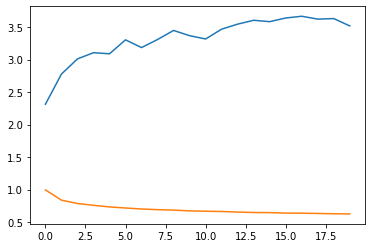

In [53]:
plt.plot(range(20), history.history['val_loss'])
plt.plot(range(20), history.history['loss'])

In [ ]:
plt.plot(range(20), history.history['val_loss'])
plt.plot(range(20), history.history['loss'])

In [ ]:
plt.plot(range(100), history.history['val_loss'])
plt.plot(range(100), history.history['loss'])

In [ ]:
y_pred = model.predict(data_splits['X_val'])
# error = mean_absolute_error(data_splits['y_val'], y_pred)
# print(f'MAE: {error:.3f}')
# rsqrd = r2_score(data_splits['y_val'],, y_pred)
# print(f'R-squared score: {rsqrd:.3f}')


# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Actual vs #predicted 3hr rainfall accumulations.')
# ax1.scatter(y_test, y_pred, s=200, c='darkblue')
# ax1.plot([0, 300], [0, 300], ls="--", c=".3")
# ax1.set_xlabel('Actual 3hr precip accumulation value')
# ax1.set_ylabel('Predicted 3hr precip_accumulation value')

# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Historgram of Actual vs predicted 3hr rainfall accumulations.')
# ax1.hist(y_test, alpha=0.5, bins=40, label='Actual')
# ax1.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
# ax1.legend()  

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
balanced_accuracy_score(data_splits['X_val'], y_pred)

In [ ]:
# plt.plot(y_pred[0] - data_splits['y_val'].iloc[0])

In [ ]:
plt.plot(y_pred[0], label='prediction')
plt.plot(data_splits['y_val'].iloc[0], label='target')
plt.legend()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(14):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > prob))
    plt.plot(np.arange(14), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(14), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(14):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(14), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(14), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(14):
        exceeding_prob.append(sum(y_pred[:, thresh] > prob))
    plt.plot(np.arange(14), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(14), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
# for prob in [ 0.001, 0.01, 0.1, 0.5, 0.75, 0.95]:
#     exceeding_prob_val = []
#     exceeding_prob_pred = []
#     for thresh in range(23):
#         exceeding_prob_val.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
#         exceeding_prob_pred.append(sum(y_pred[:, thresh] > prob))
#     plt.plot(np.arange(23), exceeding_prob_val, label=f'actual vals')
#     plt.plot(np.arange(23), exceeding_prob_pred, label=f'predicted vals')
#     plt.title(f'nsamples with frac > {prob}')
#     plt.xticks(np.arange(23), data_splits['y_train'].columns, rotation=90)
#     plt.legend()
#     plt.gcf().set_size_inches(10, 5)
#     plt.show()

In [ ]:
for thresh in range(23): 
    bins=np.linspace(0,1,51)
    # plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, ) # log=True,stacked=True, density=True
    # plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,) #log=True,  stacked=True, density=True
    plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, histtype='step', log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()
    
#     error = mean_absolute_error(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'MAE: {error:.3f}')
#     rsqrd = r2_score(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'R-squared score: {rsqrd:.3f}')
    